Problem Description:
The goal of this notebook is to demonstrate the use of cycle GANs to recreate photos in the style of Monet. Cycle GANs are an extremely effective approach for these kinds of tasks because GANs (Generative Advisary Networks) are able to create new information/data.

At a high level, this cycle GAN has two major parts: 1) the Generator and 2) the Discriminator. The Discriminator is trained on a dataset so that it can accurately determine if something belongs or doesn't belong to a repertoire. However, the Generator is constantly learning against the Discriminator and evolves its machinery in order to fool the Discriminator.

In this problem, we are given 300 pieces created by Monet to learn from. Then, we are given >7,000 real photographs with which we are to recreate in the style of Monet.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
import zipfile
from PIL import Image
import shutil

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import glob
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [256, 256])
    image = (image * 2) - 1  # Normalize to [-1,1]
    return image

def load_dataset(folder):
    image_paths = glob.glob(os.path.join(folder, '*.jpg'))
    if not image_paths:
        raise ValueError(f"No images found in {folder}. Check the dataset path.")
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(1)
    return dataset

In [3]:
monet_folder = '/kaggle/input/gan-getting-started/monet_jpg'
photo_folder = '/kaggle/input/gan-getting-started/photo_jpg'

dataset_monet = load_dataset(monet_folder)
dataset_photo = load_dataset(photo_folder)

First, we can look at some examples of Monet. Here we show the first 5 pieces by the artist in our dataset. We then can compare it to the first 5 photographs in our real photos dataset.

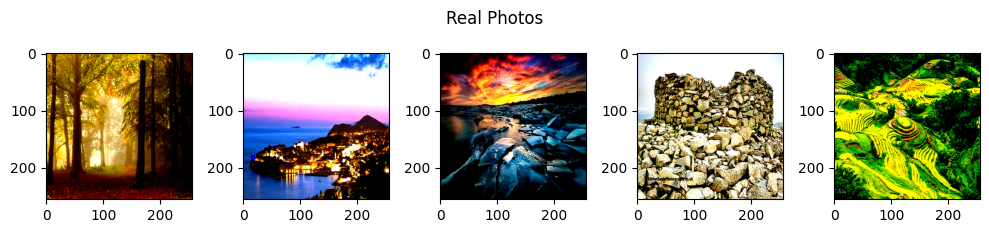

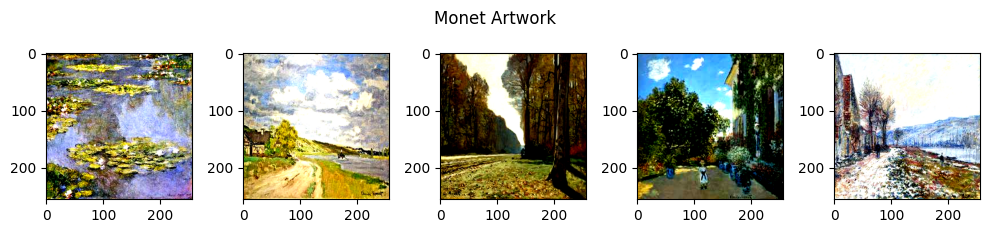

In [4]:
n = 5
fig, ax = plt.subplots(1,n, figsize=(10,10))
for i, photo in enumerate(dataset_photo.take(n)):
    ax[i].imshow((photo[0]+1/2))
plt.suptitle('Real Photos', y=0.6)
plt.tight_layout()
plt.show()

fix, ax = plt.subplots(1,n, figsize=(10,10))
for i, monet in enumerate(dataset_monet.take(n)):
    ax[i].imshow((monet[0]+1/2))
plt.suptitle('Monet Artwork', y=0.6)
plt.tight_layout()
plt.show()

Second, we can try to disect Monet's style through some simple Exploratory Data Analysis (EDA). We are already given that both the Monet pieces and the photographs are the same size (256x256x3), so size can be ruled out of things to investigate.

However, we can extrapolate the Red, Green, and Blue channels from Monet's artwork to see the distribution of the uses of primary colors. This could give insight into his preferred ways of using and mixing colors. Likewise, we can do the same for the photographs. By comparing the 2 histograms, we can see what colors should be used more or less in order to make the photographs appear to be drawn by Monet.

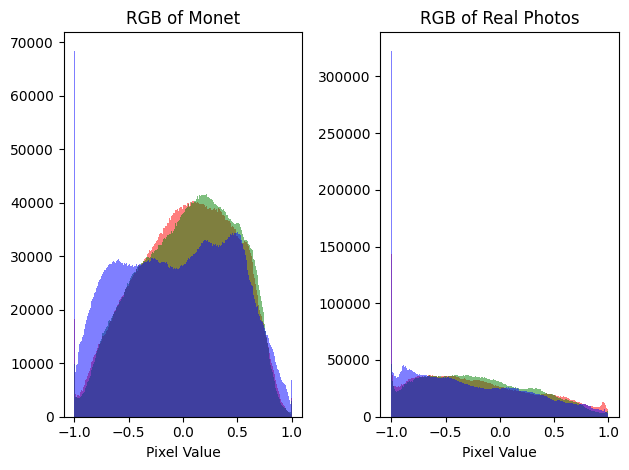

In [8]:
n = 100
monet_r, monet_g, monet_b = [], [], []
for i, image_batch in enumerate(dataset_monet.take(n)):
    r, g, b = tf.split(image_batch, num_or_size_splits=3, axis=-1)
    
    monet_r.extend(tf.reshape(r, [-1]).numpy())
    monet_g.extend(tf.reshape(g, [-1]).numpy())
    monet_b.extend(tf.reshape(b, [-1]).numpy())

photo_r, photo_g, photo_b = [], [], []
for i, image_batch in enumerate(dataset_photo.take(n)):
    r, g, b = tf.split(image_batch, num_or_size_splits=3, axis=-1)
    
    photo_r.extend(tf.reshape(r, [-1]).numpy())
    photo_g.extend(tf.reshape(g, [-1]).numpy())
    photo_b.extend(tf.reshape(b, [-1]).numpy())

fig, ax = plt.subplots(1,2)
# plt.figure(figsize=(8, 6))
ax[0].hist(monet_r, bins=256, color='red', alpha=0.5)
ax[0].hist(monet_g, bins=256, color='green', alpha=0.5)
ax[0].hist(monet_b, bins=256, color='blue', alpha=0.5)
ax[0].set_title("RGB of Monet")
ax[0].set_xlabel("Pixel Value")
ax[1].hist(photo_r, bins=256, color='red', alpha=0.5)
ax[1].hist(photo_g, bins=256, color='green', alpha=0.5)
ax[1].hist(photo_b, bins=256, color='blue', alpha=0.5)
ax[1].set_title("RGB of Real Photos")
ax[1].set_xlabel("Pixel Value")
plt.tight_layout()
plt.show()

In [5]:
def generator():
    inputs = layers.Input(shape=(256, 256, 3))
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(128, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(3, (3, 3), padding='same', activation='relu')(x) 
    return keras.Model(inputs, x)

def discriminator():
    inputs = layers.Input(shape=(256, 256, 3))
    x = layers.Conv2D(64, (3, 3), strides=2, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(128, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), strides=2, padding='same', activation='relu')(x)
    return keras.Model(inputs, x)

loss_object = keras.losses.MeanSquaredError()

def generator_loss(fake_output):
    return loss_object(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = loss_object(tf.ones_like(real_output), real_output)
    fake_loss = loss_object(tf.zeros_like(fake_output), fake_output)
    return (real_loss + fake_loss)


def cycle_loss(real_image, cycled_image):
    return tf.reduce_mean(tf.abs(real_image - cycled_image))

def identity_loss(real_image, same_image):
    return tf.reduce_mean(tf.abs(real_image - same_image))

generator_optimizer = keras.optimizers.Adam(learning_rate=2e-4)
discriminator_optimizer = keras.optimizers.Adam(learning_rate=2e-4)

generator_photo_to_monet = generator()
discriminator_monet = discriminator()

def train_step(real_photo, real_monet):
    with tf.GradientTape(persistent=True) as tape:
        fake_monet = generator_photo_to_monet(real_photo, training=True)
        cycled_photo = generator_photo_to_monet(fake_monet, training=True)
        same_monet = generator_photo_to_monet(real_monet, training=True)
        
        fake_monet_output = discriminator_monet(fake_monet, training=True)
        real_monet_output = discriminator_monet(real_monet, training=True)

        gen_loss = generator_loss(fake_monet_output)
        disc_loss = discriminator_loss(real_monet_output, fake_monet_output)
        cycle_consistency_loss = cycle_loss(real_photo, cycled_photo)
        identity_mapping_loss = identity_loss(real_monet, same_monet)

        total_gen_loss = gen_loss + cycle_consistency_loss + identity_mapping_loss
        total_disc_loss = disc_loss

    gradients_gen = tape.gradient(total_gen_loss, generator_photo_to_monet.trainable_variables)
    gradients_disc = tape.gradient(total_disc_loss, discriminator_monet.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_gen, generator_photo_to_monet.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_disc, discriminator_monet.trainable_variables))

    return total_gen_loss, total_disc_loss

In [6]:
EPOCHS = 100
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    for real_photo, real_monet in zip(dataset_photo, dataset_monet):
        gen_loss, disc_loss = train_step(real_photo, real_monet)
    print(f"Generator Loss: {gen_loss.numpy():.4f}, Discriminator Loss: {disc_loss.numpy():.4f}")

Epoch 1/100
Generator Loss: 1.2460, Discriminator Loss: 0.4059
Epoch 2/100
Generator Loss: 1.1524, Discriminator Loss: 0.4353
Epoch 3/100
Generator Loss: 1.1847, Discriminator Loss: 0.4174
Epoch 4/100
Generator Loss: 1.1960, Discriminator Loss: 0.4167
Epoch 5/100
Generator Loss: 1.2310, Discriminator Loss: 0.3955
Epoch 6/100
Generator Loss: 1.2532, Discriminator Loss: 0.4157
Epoch 7/100
Generator Loss: 1.1409, Discriminator Loss: 0.4733
Epoch 8/100
Generator Loss: 1.2305, Discriminator Loss: 0.4498
Epoch 9/100
Generator Loss: 1.3111, Discriminator Loss: 0.4247
Epoch 10/100
Generator Loss: 1.2094, Discriminator Loss: 0.4669
Epoch 11/100
Generator Loss: 1.2136, Discriminator Loss: 0.3914
Epoch 12/100
Generator Loss: 1.2401, Discriminator Loss: 0.4316
Epoch 13/100
Generator Loss: 1.1421, Discriminator Loss: 0.4183
Epoch 14/100
Generator Loss: 1.2021, Discriminator Loss: 0.4719
Epoch 15/100
Generator Loss: 1.1913, Discriminator Loss: 0.4593
Epoch 16/100
Generator Loss: 1.3904, Discriminato

After training our model for 100 epochs, we can then pull out examples to see what exactly our cycle GAN is doing. Here we pull out the first 5 examples of our algorithm and compare it to their original photos. 

What we can see now is that the GAN thinks that the colors should be shifted to lighter and brighter hues. To my eye, these generated photos don't look very Monet-like, which could be due to that the Generator loss has very small improvements over the 100 epochs, which can be interpreted as not many changes have happened. However, the Discriminator loss improved better compared to early epochs, meaning the Discriminator at least was impproving.

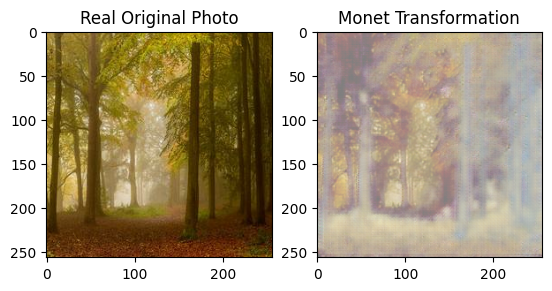

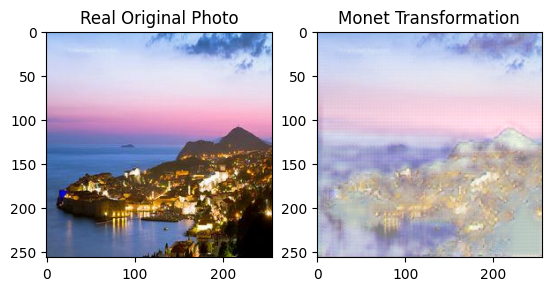

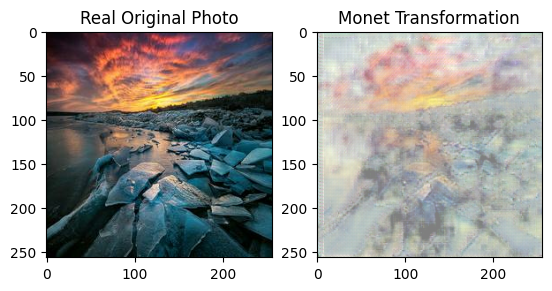

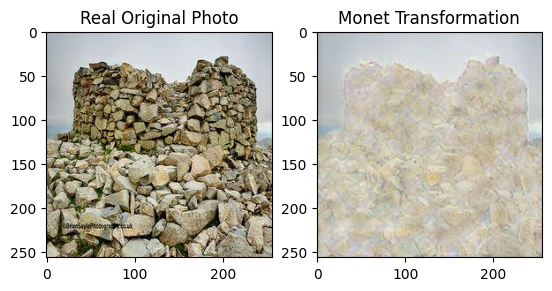

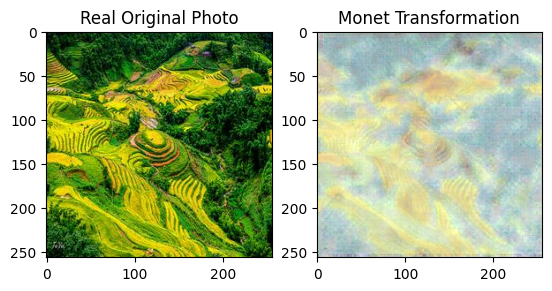

In [10]:
def generate_monet_image(photo):
    generated_image = generator_photo_to_monet(tf.expand_dims(photo, axis=0))[0]
    return (generated_image.numpy()+1)/2  # Convert from [-1,1] to [0,1] for visualization

for photo in dataset_photo.take(5):
    monet_image = generate_monet_image(photo[0])

    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.imshow((photo[0]+1)/2)
    ax2.imshow(monet_image)
    ax1.set_title('Real Original Photo')
    ax2.set_title('Monet Transformation')
    plt.show()

In conclusion, we were able to create a cycle GAN and according Kaggle, it scored a 107. Improvements that can be made are of course increasing epoch numbers, adjusting other hyperparameters such as learning_rate, beta_1, beta_2, etc. We could also add more neurons to make the training more complex, or use different activations such as tanh instead of relu.

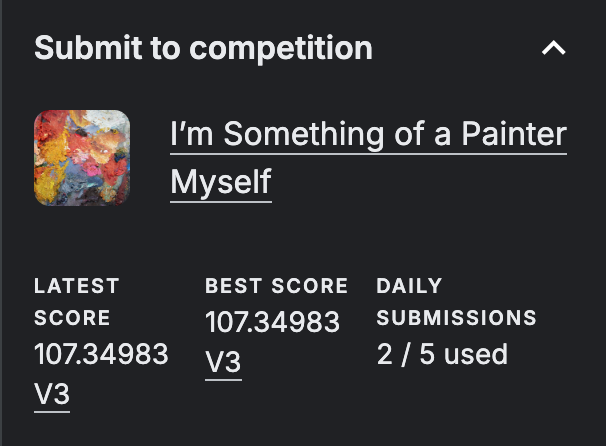

In [ ]:
OUTPUT_DIR = "/kaggle/working/images.zip"

def save_image(image_array, file_path):
    image = (image_array * 255).astype(np.uint8) 
    image = Image.fromarray(image) 
    image.save(file_path, format="JPEG") 

def process_and_save_images(dataset, output_zip=OUTPUT_DIR):
    temp_dir = "generated_images"
    os.makedirs(temp_dir, exist_ok=True) 
    image_paths = []
    
    for i, photo in enumerate(dataset):
        monet_image = generate_monet_image(photo[0])  
        file_path = os.path.join(temp_dir, f"image_{i+1}.jpg")
        save_image(monet_image, file_path)  # Save image
        image_paths.append(file_path)
            
    with zipfile.ZipFile(output_zip, 'w') as zipf:
        for file_path in image_paths:
            zipf.write(file_path, os.path.basename(file_path))

    print(f"Saved {len(image_paths)} images in {output_zip}")

process_and_save_images(dataset_photo)